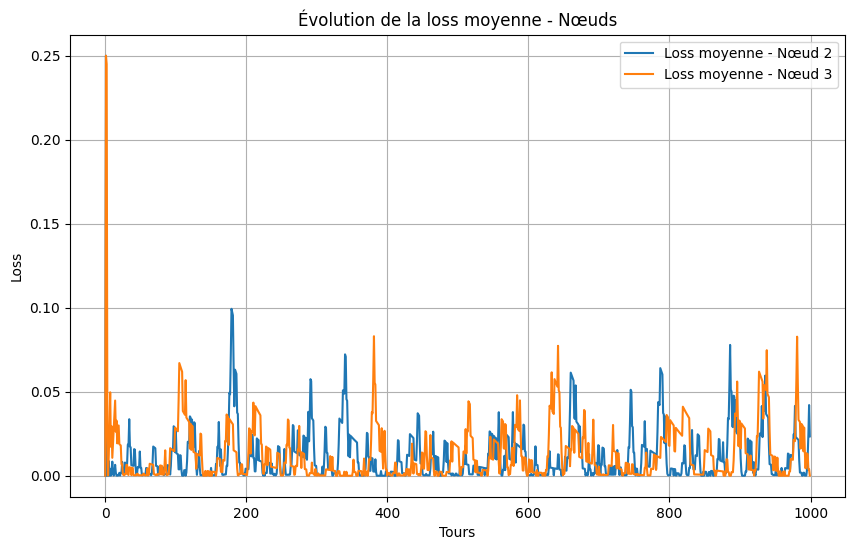

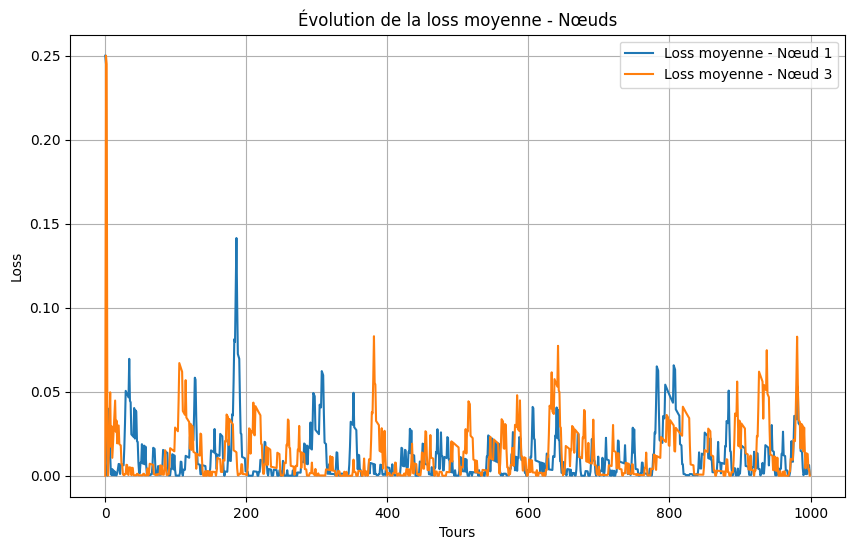

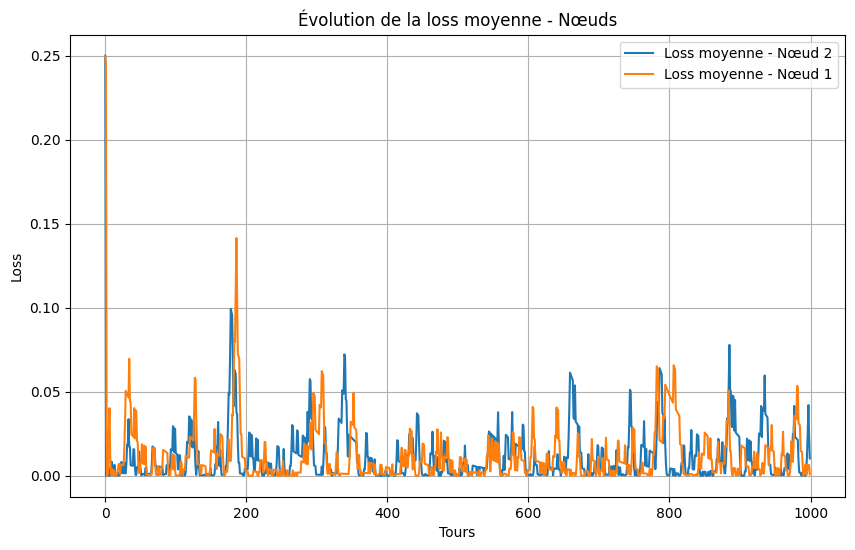


--- Comparaison des p-values ---

Nœud 1 - Comparaison des p-values:
  Nœud 2 - Estimé: 0.5015, Vrai: 0.5000, Erreur: 0.0015
  Nœud 3 - Estimé: 0.6610, Vrai: 0.6667, Erreur: 0.0057

Nœud 2 - Comparaison des p-values:
  Nœud 1 - Estimé: 0.3218, Vrai: 0.3333, Erreur: 0.0115
  Nœud 3 - Estimé: 0.6610, Vrai: 0.6667, Erreur: 0.0057

Nœud 3 - Comparaison des p-values:
  Nœud 2 - Estimé: 0.5005, Vrai: 0.5000, Erreur: 0.0005
  Nœud 1 - Estimé: 0.3218, Vrai: 0.3333, Erreur: 0.0115


In [ ]:
import random
import matplotlib.pyplot as plt

class Node:
    Nodes = {}  # Dictionnaire pour stocker tous les nœuds
    p_values = {}

    def __init__(self, node_id, p_one_value, buffer_size=20, learning_rate=0.001):
        """
        Initialise un nœud.
        
        :param node_id: Identifiant unique du nœud.
        :param p_one_value: Probabilité de succès d'envoi d'un message (entre 0 et 1).
        :param buffer_size: Taille maximale du buffer pour stocker les messages reçus.
        :param learning_rate: Taux d'apprentissage pour la descente de gradient.
        """
        self.node_id = node_id
        self.p_one_value = p_one_value
        self.buffer_size = buffer_size
        self.buffer = {}
        self.connected_nodes = []  # Liste des nœuds connectés
        self.p_values = {}  # Dictionnaire pour stocker les estimations de p-value des autres nœuds
        self.learning_rate = learning_rate  # Taux d'apprentissage pour la descente de gradient
        self.loss_history = {}  # Historique des erreurs locales
        Node.Nodes[node_id] = self
        Node.p_values[node_id] = 0.5  # Initialiser la p-value à 0.5 (aucune information)
        self.sents_message=[]

    def connect(self, other_node):
        """
        Connecte ce nœud à un autre nœud.
        
        :param other_node: Un autre objet Node auquel ce nœud se connecte.
        """
        if other_node not in self.connected_nodes:
            self.connected_nodes.append(other_node)
            self.p_values[other_node.node_id] = 0.5  # Initialiser la p-value à 0.5 (aucune information)

    @staticmethod
    def connect_nodes(list_nodes):
        """
        Connecte les nœuds entre eux.
        """
        for node1, node2 in list_nodes:
            Node.Nodes[node1].connect(Node.Nodes[node2])
            Node.Nodes[node2].connect(Node.Nodes[node1])

    def send_message(self,p_one_value):
        """
        Simule l'envoi d'un message avec une probabilité de succès donnée.
        
        :return: 1 si le message est envoyé avec succès, 0 sinon.
        """
        if random.random() < p_one_value:
            return 1  # Succès
        else:
            return 0  # Échec
        
    def send_message_2(self,p_one_value,buffer):

        if not buffer:
            bit = self.send_message(p_one_value)
            buffer.append(bit)
            return bit

        actual_pvalue_0= sum(buffer)/(len(buffer)+1)
        actual_pvalue_1= (sum(buffer)+1)/(len(buffer)+1)

        distance_0= abs(p_one_value-actual_pvalue_0)
        distance_1= abs(p_one_value-actual_pvalue_1)
        if distance_0 < distance_1:
            return 0
        else:
            return 1
        

    def guess_bit(self,p_one_value,buffer):
        """
        Devine le bit d'un nœud en fonction des p-values estimées des nœuds connectés.
        """
        if not buffer:
            return self.send_message(p_one_value)
        actual_pvalue_0= sum(buffer)/(len(buffer)+1)
        actual_pvalue_1= (sum(buffer)+1)/(len(buffer)+1)

        distance_0= abs(p_one_value-actual_pvalue_0)
        distance_1= abs(p_one_value-actual_pvalue_1)

        if distance_0 < distance_1:
            return 0
        else:
            return 1


    def receive_message(self, message, sender_id):
        """
        Reçoit un message et l'ajoute au buffer si celui-ci n'est pas plein.
        
        :param message: Le message reçu.
        :param sender_id: L'identifiant du nœud envoyeur.
        """

        messages = self.buffer.get(sender_id, [])
        if len(messages) < self.buffer_size:
            messages.append(message)
        else:
            # Retirer le message le plus ancien
            messages.pop(0)
            messages.append(message)
        self.buffer[sender_id] = messages
        

    def compute_error(self, sender_id):
        """
        Calcule l'erreur entre la p-value estimée et la valeur observée.
        
        :param sender_id: L'identifiant du nœud envoyeur.
        :param observed_value: La valeur observée (0 ou 1).
        :return: L'erreur.
        """
        if sender_id not in self.buffer or len(self.buffer[sender_id]) == 0:
            return 0 
        other_node = Node.get_node(sender_id)
        # true_p = other_node.p_one_value
        true_p = sum(self.buffer[sender_id]) / len(self.buffer[sender_id])

        predicted_p = self.p_values.get(sender_id, 0.5)

        error = true_p - predicted_p
        return error

    def gradient_descent_update(self, sender_id, error):
        """
        Met à jour la p-value estimée en utilisant la descente de gradient.
        
        :param sender_id: L'identifiant du nœud envoyeur.
        :param error: L'erreur calculée.
        """
        if sender_id in self.p_values:
            self.p_values[sender_id] += self.learning_rate * error
            # S'assurer que la p-value reste dans l'intervalle [0, 1]
            self.p_values[sender_id] = max(0, min(1, self.p_values[sender_id]))


    def guess_other_node(self):
        """
        Devine la valeur d'un autre nœud en fonction des p-values estimées des nœuds connectés.
        """
        guess={}
        for other_node in self.connected_nodes:
            guess[other_node.node_id]= self.guess_bit(other_node.p_one_value,self.buffer.get(other_node.node_id, []))
        return guess
    
    @staticmethod
    def turn():
        """
        Traite un tour complet pour tous les nœuds.
        """
    

        for node in Node.Nodes.values():
            node.process_turn()



           

    def process_turn(self):
        """
        Traite un tour complet pour ce nœud :
        1. Envoie un message à tous les nœuds connectés.
        2. Reçoit les messages des nœuds connectés.
        3. Estime les p-values et met à jour avec la descente de gradient.
        4. Calcule et affiche la loss.
        """
        # Envoyer un message à tous les nœuds connectés
        # send_result = self.send_message(self.p_one_value)
        send_result = self.send_message_2(self.p_one_value,self.sents_message[-self.buffer_size:])
        # send_result = self.send_message_2(self.p_one_value,self.sents_message)
        # print(f"Nœud {self.node_id} a envoyé un message -> Résultat: {send_result}")

        # Recevoir les messages des nœuds connectés
        for other_node in self.connected_nodes:
            other_node.receive_message(send_result, self.node_id)

        # Estimer les p-values et mettre à jour avec la descente de gradient
        total_loss = 0
        for other_node in self.connected_nodes:

        
                error = self.compute_error(other_node.node_id)
                self.gradient_descent_update(other_node.node_id, error)
                total_loss += error ** 2  # Loss = erreur au carré (MSE)
                if other_node.node_id not in self.loss_history:
                    self.loss_history[other_node.node_id] = []
                self.loss_history[other_node.node_id].append(error ** 2)
                
    @staticmethod
    def get_node(node_id):
        return Node.Nodes[node_id]

 
    @staticmethod
    def plot_loss_historys():
        """
        Affiche l'historique des erreurs globales avec matplotlib.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(Node.loss_history, label="Loss moyenne globale")
        plt.xlabel("Tours")
        plt.ylabel("Loss")
        plt.title("Évolution de la loss moyenne globale")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_loss_history(self):
        """
        Affiche l'historique des erreurs locales avec matplotlib.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history, label=f"Loss moyenne - Nœud {self.node_id}")
        plt.xlabel("Tours")
        plt.ylabel("Loss")
        plt.title(f"Évolution de la loss moyenne - Nœud {self.node_id}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_loss_history_all(self):
        """
        Affiche l'historique des erreurs locales avec matplotlib.
        """
        plt.figure(figsize=(10, 6))
        for node_id, loss_history in self.loss_history.items():
            plt.plot(loss_history, label=f"Loss moyenne - Nœud {node_id}")
        plt.xlabel("Tours")
        plt.ylabel("Loss")
        plt.title(f"Évolution de la loss moyenne - Nœuds")
        plt.legend()
        plt.grid(True)
        plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    # Créer des nœuds
    node1 = Node(node_id=1, p_one_value=1/3, learning_rate=0.01)
    node2 = Node(node_id=2, p_one_value=1/2, learning_rate=0.01)
    node3 = Node(node_id=3, p_one_value=2/3, learning_rate=0.01)


    # Connecter les nœuds
    Node.connect_nodes([(1, 2), (2, 3), (3, 1)])


    num_turns = 1000
    for turn in range(num_turns):
        # print(f"\n--- Tour {turn + 1} ---")
        Node.turn()
 
        
    # Afficher l'historique des erreurs pour chaque nœud
    node1.plot_loss_history_all()
    node2.plot_loss_history_all()
    node3.plot_loss_history_all()

    # Comparer les p-values estimées avec les vraies p-values
    print("\n--- Comparaison des p-values ---")
    true_p_values = {
        1: 1/3,
        2: 1/2,
        3: 2/3
    }


    for node in [node1, node2, node3]:
        print(f"\nNœud {node.node_id} - Comparaison des p-values:")
        for other_node_id, estimated_p in node.p_values.items():
            true_p = true_p_values[other_node_id]
            print(f"  Nœud {other_node_id} - Estimé: {estimated_p:.4f}, Vrai: {true_p:.4f}, Erreur: {abs(estimated_p - true_p):.4f}")
    